In [1]:
import os
os.chdir('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from GLM_regression import *
%load_ext autoreload
%autoreload 2


plt.rcParams.update({'font.size': 10,
                    'axes.spines.right': False,
                    'axes.spines.top':   False,
                    'legend.frameon':       False,})


# plt.rcParams.update({'font.size': 10,
#                     'axes.spines.right': False,
#                     'axes.spines.top':   False,
#                     'legend.frameon':       False,
#                     'font.sans-serif': 'Helvetica',
#                     'svg.fonttype': 'none'})

In [16]:
filename = "SSTindivsomata_GLM.mat"
# filename = "NDNFindivsomata_GLM.mat"
# filename = "EC_GLM.mat"

filepath = os.path.join("datasets", filename)
reorganized_data, variable_list = preprocess_data(filepath)
# GLM_params = fit_GLM(reorganized_data, quintile=None, regression='ridge')

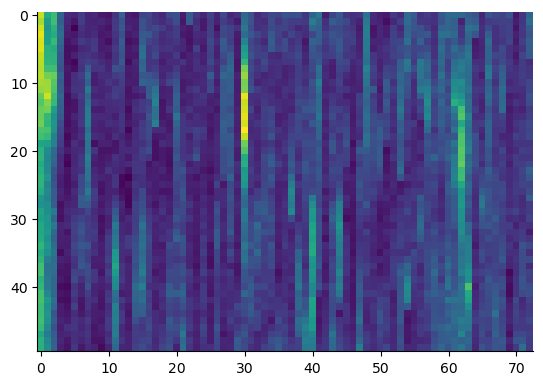

In [20]:
plt.imshow(reorganized_data['animal_3']['cell_2'][:,0,:])

In [ ]:
plot_combined_figure(reorganized_data, GLM_params, variable_list, model_name=filename.split('.')[0], sort_by='R2')

In [ ]:
# plot_R2_distribution([GLM_params,GLM_params_nolicks, GLM_params_noRlocs], title=filename)

In [ ]:
# plot_example_neuron(reorganized_data, GLM_params, variable_list, sort_by="Speed")
# plot_example_neuron(reorganized_data, GLM_params, variable_list, animal='animal_1', neuron=1)
# plot_GLM_summary_data(GLM_params, variable_list)

In [ ]:
# datasets = ["SSTindivsomata_GLM.mat", "NDNFindivsomata_GLM.mat", "EC_GLM.mat"]

# fig = plt.figure(figsize=(18, 8))
# axes = gs.GridSpec(nrows=len(datasets), ncols=4, hspace=0.6, wspace=0.3)

# for i,filename in enumerate(datasets):
#     filepath = os.path.join("datasets", filename)
#     reorganized_data, variable_list = load_data(filepath)
#     GLM_params_start = fit_GLM(reorganized_data, quintile=1, regression='ridge')
#     GLM_params_end = fit_GLM(reorganized_data, quintile=5, regression='ridge')
#     delta_weights = calculate_delta_weights(reorganized_data, GLM_params_start, GLM_params_end)

#     ax = fig.add_subplot(axes[i, 1])
#     plot_GLM_summary_data(GLM_params_start, variable_list, ax=ax)
#     ax.set_title('First quintile')
    
#     ax = fig.add_subplot(axes[i, 2])
#     plot_GLM_summary_data(GLM_params_end, variable_list, ax=ax)
#     ax.set_title('Last quintile')

#     ax = fig.add_subplot(axes[i, 3])
#     plot_R2_distribution(GLM_params_start, GLM_params_end, ax=ax)
#     ax.set_xlim([0.5, 3.5])

#     ax = fig.add_subplot(axes[i, 0])
#     plot_delta_weights_summary(delta_weights, variable_list, model_name=filepath.split('.')[0], ax=ax)

#     if i == 0:
#         ax.scatter([],[], color='gray', label='Neurons', s=20)
#         ax.scatter([],[], color='black', label='Animal avg', s=20)
#         ax.scatter([],[], color='red', label='Overall avg', s=20)
#         ax.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=False, handletextpad=0.5, labelspacing=0.2, borderpad=0)

# fig.savefig('figures/delta_weights_summary.png', dpi=300)

In [ ]:
residual_activity, avg_residuals = compute_residual_activity(GLM_params, reorganized_data)

plt.plot(avg_residuals.T, c='gray', alpha=0.1)   
plt.plot(np.mean(avg_residuals, axis=0), c='r', lw=2) 
plt.xlim([0, 50])
plt.xlabel('Position')
plt.show()

In [ ]:
def filter_neurons_by_metric(reorganized_data, GLM_params, variable_list, metric='R2', threshold=0.9, scale_type='std', keep='top'):
    GLM_r2 = get_GLM_R2(GLM_params)
    weights = get_GLM_weights(GLM_params, variable_list)

    metrics_dict = {**weights, 'R2': GLM_r2}
    metric_values = metrics_dict[metric]
    
    filtered_GLM = copy.deepcopy(GLM_params)
    filtered_data = copy.deepcopy(reorganized_data)
    neuron_idx = 0
    for animal in filtered_GLM:
        neurons_to_remove = []
        for neuron in filtered_GLM[animal]:
            metric_value = metric_values[neuron_idx]

            # Define thresholds based on scale type
            if scale_type == 'std':
                mean_val = np.mean(metric_values)
                std_val = np.std(metric_values)
                upper_bound = mean_val + threshold * std_val
                lower_bound = mean_val - threshold * std_val

            elif scale_type == 'percentile':
                upper_bound = np.percentile(metric_values, 100 - threshold)
                lower_bound = np.percentile(metric_values, threshold)

            elif scale_type == 'value':
                upper_bound = threshold
                lower_bound = threshold

            # Apply filtering based on filter type
            if (keep == 'top' and metric_value < upper_bound) or \
               (keep == 'bottom' and metric_value > lower_bound):
                neurons_to_remove.append(neuron)

            neuron_idx += 1

        print(neurons_to_remove)
        print(animal, filtered_GLM[animal].keys())
        print(animal, len(filtered_data[animal]))

        for neuron in neurons_to_remove:
            filtered_GLM[animal].pop(neuron)
        
        filtered_data[animal] = filtered_data[animal][~np.isin(np.arange(len(filtered_data[animal])), neurons_to_remove)]

    return filtered_data, filtered_GLM

filtered_data, filtered_GLM = filter_neurons_by_metric(reorganized_data, GLM_params, variable_list, metric='R2', threshold=0.9, scale_type='std', keep='top')

In [ ]:
a = [(2,3),3,4,5]
idx_to_remove = slice(0,1,2,3)
b = a[idx_to_remove]
b

In [ ]:
quintile = 1
GLM_params_1 = fit_GLM(reorganized_data, quintile=quintile, regression='ridge', renormalize=False)
vars_to_remove = variable_list.copy()[1:] + ['intercept']
vars_to_remove.remove('Speed')
filtered_GLM_params_1 = remove_variables_from_glm(GLM_params_1, vars_to_remove, variable_list)
residual_activity_1, avg_residuals_1 = compute_residual_activity(filtered_GLM_params_1, reorganized_data, quintile=quintile)

quintile = 5
GLM_params_5 = fit_GLM(reorganized_data, quintile=quintile, regression='ridge', renormalize=False)
vars_to_remove = variable_list.copy()[1:] + ['intercept']
vars_to_remove.remove('Speed')
filtered_GLM_params_5 = remove_variables_from_glm(GLM_params_5, vars_to_remove, variable_list)
residual_activity_5, avg_residuals_5 = compute_residual_activity(filtered_GLM_params_5, reorganized_data, quintile=quintile)

sorting_idx_5 = np.argsort(np.argmax(avg_residuals_5, axis=1))
avg_residuals_1 = avg_residuals_1[sorting_idx_5]
avg_residuals_5 = avg_residuals_5[sorting_idx_5]



In [ ]:
fig = plt.figure(figsize=(14, 14))
fig.suptitle(filename, fontsize=14, y=0.95)
axes = gs.GridSpec(nrows=3, ncols=3, hspace=0.2, wspace=0.2, height_ratios=[3,1,2])

vmax = np.max([np.abs(avg_residuals_1), np.abs(avg_residuals_5)])
plot_scale = np.max([np.abs(np.mean(avg_residuals_1, axis=0))+np.std(avg_residuals_1, axis=0), np.abs(np.mean(avg_residuals_5, axis=0))+np.std(avg_residuals_5, axis=0)])

# Heatmap 1
ax = fig.add_subplot(axes[0,0])
im = ax.imshow(avg_residuals_1, aspect='auto', cmap='bwr', vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(im, ax=ax)
ax.set_xlim([0, 50])
ax.set_title('First 20% of trials')
ax.set_ylabel('Neuron #')

# Plot avg 1
ax = fig.add_subplot(axes[1,0])
ax.plot(np.mean(avg_residuals_1, axis=0), c='k', lw=2)
std = np.std(avg_residuals_1, axis=0)
sem = std / np.sqrt(avg_residuals_1.shape[0])
ax.fill_between(np.arange(50), np.mean(avg_residuals_1, axis=0)-std, np.mean(avg_residuals_1, axis=0)+std, color='gray', alpha=0.2)
ax.hlines(0, 0, 50, color='gray', linestyle='--')
ax.set_xlim([0, 50])
ax.set_ylim([-plot_scale, plot_scale])
ax.set_ylabel('Residual activity (Z-score)')
ax.set_xlabel('Position')

# Heatmap 2
ax = fig.add_subplot(axes[0,1])
im = ax.imshow(avg_residuals_5, aspect='auto', cmap='bwr', vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(im, ax=ax)
ax.set_xlim([0, 50])
ax.set_title('Last 20% of trials')

# Plot avg 2
ax = fig.add_subplot(axes[1,1])
ax.plot(np.mean(avg_residuals_5, axis=0), c='k', lw=2)
std = np.std(avg_residuals_5, axis=0)
sem = std / np.sqrt(avg_residuals_5.shape[0])
ax.fill_between(np.arange(50), np.mean(avg_residuals_5, axis=0)-std, np.mean(avg_residuals_5, axis=0)+std, color='gray', alpha=0.2)
ax.set_xlim([0, 50])
ax.set_ylim([-plot_scale, plot_scale])
ax.set_xlabel('Position')
ax.hlines(0, 0, 50, color='gray', linestyle='--')

# Plot delta
delta_residuals = avg_residuals_5 - avg_residuals_1
ax = fig.add_subplot(axes[0,2])
vmax = np.max(np.abs(delta_residuals))
im = ax.imshow(delta_residuals, aspect='auto', cmap='bwr', vmin=-vmax, vmax=vmax)
cbar = fig.colorbar(im, ax=ax)
ax.set_xlim([0, 50])
ax.set_title('Difference')

ax = fig.add_subplot(axes[1,2])
ax.plot(np.mean(delta_residuals, axis=0), c='k', lw=2)
std = np.std(delta_residuals, axis=0)
sem = std / np.sqrt(delta_residuals.shape[0])
ax.fill_between(np.arange(50), np.mean(delta_residuals, axis=0)-std, np.mean(delta_residuals, axis=0)+std, color='gray', alpha=0.2)
ax.set_xlim([0, 50])
ax.set_xlabel('Position')
ax.hlines(0, 0, 50, color='gray', linestyle='--')

ax = fig.add_subplot(axes[2,:])
delta_weights = calculate_delta_weights(GLM_params_1, GLM_params_5)
plot_delta_weights_summary(delta_weights, variable_list, model_name=None, save=False, ax=ax)

fig.savefig(f'figures/{filename.split(".")[0]}_residuals.png', dpi=300)
fig.savefig(f'figures/{filename.split(".")[0]}_residuals.svg', dpi=300)


In [ ]:
def compute_velocity_corrected_residuals(residual_activity, reorganized_data):
    velocity_corrected_residuals = {}
    bin_size_cm = 180/50
    for animal in reorganized_data:
        velocity_corrected_residuals[animal] = {}
        for i,neuron_data in enumerate(reorganized_data[animal]):
            neuron_data = neuron_data[:,:,~np.isnan(neuron_data).any(axis=(0,1))]
            velocity = neuron_data[:,3]
            neuron_residual = residual_activity[animal][i] / velocity * bin_size_cm
            velocity_corrected_residuals[animal][i] = neuron_residual
    return velocity_corrected_residuals

# vars_to_remove = variable_list[4:] + ['R_loc']
# filtered_GLM_params = remove_variables_from_glm(GLM_params, vars_to_remove, variable_list)
# residual_activity = compute_residual_activity(filtered_GLM_params, reorganized_data)
# residual_activity = compute_velocity_corrected_residuals(residual_activity, reorganized_data)

In [ ]:
plt.plot(avg_residuals_5[4])
# plt.hist(avg_residuals_5[4], bins=50)